In [1]:
# compute time series of metrics for companies
# Will focus on ONE INDUSTRY only right now: mobile service
import pandas as pd

# reading in the convs df
convs_df = pd.read_csv("data/conversations.csv")
convs_df["time"] = pd.to_datetime(convs_df["time"])
convs_df.head()

,conv_id,company,tweet_ids,time,avg_cust_sent,cust_sent_improvement,comp_resp_timehrs,issue_was_resolved
0,1757947,Ask_WellsFargo,"1757947,1757946,1757945",2010-02-16 15:49:47,-0.400000,0.2,67204.866389,0
1,2984140,Ask_WellsFargo,"2984140,2984139,2984138",2011-10-17 18:00:43,-0.450000,-0.9,53423.852222,0
2,255331,Ask_WellsFargo,"255331,255335,1769251,255339,255330,677776,677...",2012-09-25 20:04:10,-0.553846,-1.2,24.860000,0
3,595098,Ask_WellsFargo,"595098,595096,595097,595099",2016-02-24 18:32:12,-0.300000,0.6,1.870833,0
4,2153951,Ask_WellsFargo,"2153951,2153949,2153947,2153948,2153950",2016-03-22 23:19:04,-0.466667,-0.2,7032.025833,0


In [2]:
# reading in the companies
comps_df = pd.read_csv("companies.csv")
comps_df.head()

,twitter_handle,industry,company_name
0,sprintcare,mobile_service,Sprint
1,USCellularCares,mobile_service,US Cellular
2,VMUcare,mobile_service,Virgin Mobile
3,ATT,mobile_service,AT&T
4,BoostCare,mobile_service,Boost Mobile


In [3]:
# examining the time stamps for the phone companies
# between Sep and Dec 2011

# focusing on industry: mobile_service
comps = comps_df["twitter_handle"][
    comps_df["industry"] == "mobile_service"].values

# keeping only relevant company rows
# convs_ind_df: conversations_industry_df
convs_ind_df = convs_df[convs_df["company"].isin(comps)]

# getting time series df for each company
comp2df_d = dict(list(convs_ind_df.groupby("company")))
list(comp2df_d.items())[0]

('ATT',
         conv_id company                                          tweet_ids  \
 775914    91114     ATT  91114,91113,91112,91109,91108,91106,91107,9111...   
 775915  1252952     ATT                            1252952,1252950,1252951   
 775916  2951325     ATT                                    2951325,2951324   
 775917   670802     ATT                        670802,670800,670801,670803   
 775918  1351595     ATT  1351595,1351594,1351593,1351592,1351591,135159...   
 775919  1448932     ATT                            1448932,1448931,1448930   
 775920   280377     ATT                        280377,280376,280374,280375   
 775921   881428     ATT                        881428,881427,881425,881426   
 775922   331228     ATT                 331228,331227,331226,331224,331225   
 775923   200794     ATT                               200794,200793,200792   
 775924   178475     ATT                        178475,178474,178473,178472   
 775925  1203300     ATT                    

<IPython.core.display.Javascript object>


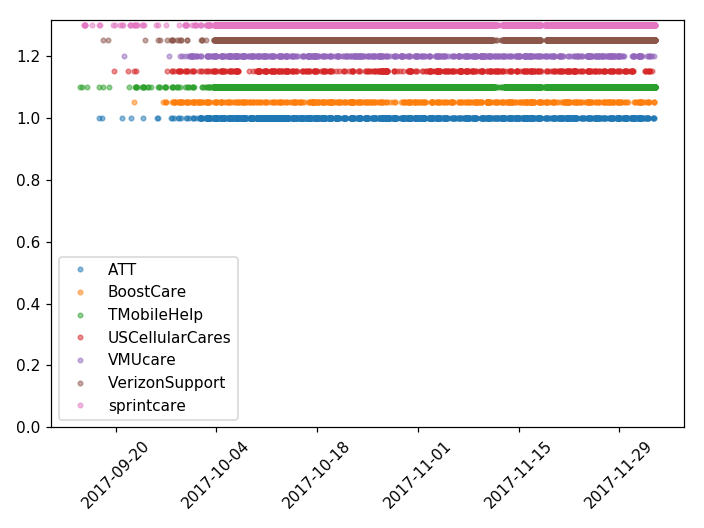

In [4]:
### visualizing the timestamps

# bounds on times
def bound_times(times):
    start_time = pd.to_datetime("2017-09-15")
    end_time = pd.to_datetime("2018-12-04")
    return times[
        (times > start_time) & (times < end_time)
        ]

# getting the time series for each company
comp2ts_d = dict(list(
    [(k, bound_times(pd.to_datetime(v["time"].values))) 
     for k, v in comp2df_d.items()]))
comp2ts_d

## plot the timeseries points for all the companies
# plot between 2017-09 and 2018-01
%matplotlib notebook
import matplotlib.pyplot as plt

ax = plt.subplots()[1]
for ix, (comp, ts) in enumerate(comp2ts_d.items()):
    ax.plot(ts, [1 + 0.05 * ix]*len(ts), label = comp,
        linestyle = "", marker = ".", alpha = 0.5)
ax.set_ylim(0, None)
plt.xticks(rotation = 45)
ax.legend()
plt.tight_layout()

# appropriate time bounds found: 2018-09-15 to 2018-12-04

<IPython.core.display.Javascript object>


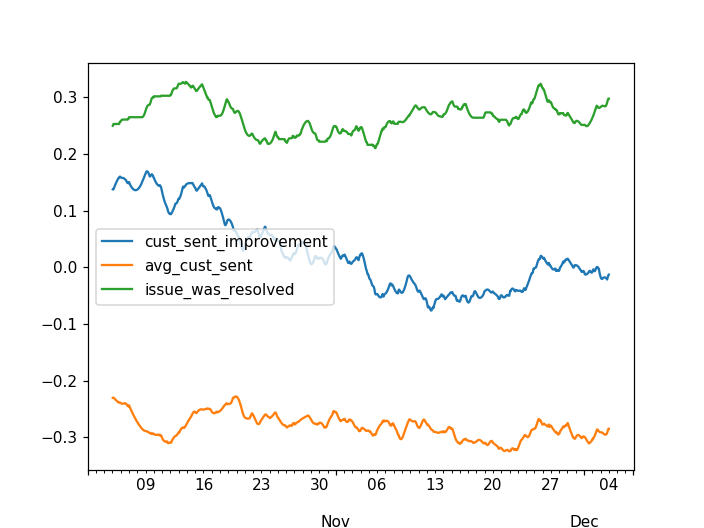

In [5]:
## bin all metrics into hour blocks (average results)

# relevant times
start_time = pd.to_datetime("2017-09-15")
end_time = pd.to_datetime("2017-12-04")

# keep only rows in relevant time range
def df_limit_times(df,
    start_time = start_time, end_time = end_time):
    return \
        df[(df["time"] > start_time) & (df["time"] < end_time)]

# make granularity of times one hour
def df_hour_granularity(df):
    # make string, chop off minutes etc, to_datetime
    df_copy = df.copy()
    df_copy["time"] = df["time"].apply(str).str[:-6] \
        .apply(pd.to_datetime)
    return df_copy
    
def df_keep_metrics_only(df):
    cols_keep = ["time", 
                 "avg_cust_sent", 
                 "cust_sent_improvement", 
                 "comp_resp_timehrs", 
                 "issue_was_resolved"]
    return df[cols_keep]

# groupby time and average
def df_groupby_time(df):
    return df.groupby("time").mean().reset_index()

# create rows for all relevant times
time_df = pd.DataFrame({
    "time": pd.date_range(start_time, end_time, freq = "1H")
    })
def df_create_missing_time_rows(df, time_df = time_df):
    return time_df.merge(df, on = "time", how = "left")

# fill nans
def df_fillna(df):
    return df.interpolate(method = "linear").fillna(0)

# smoothen data
def df_rolling_mean(df):
    # rolling means
    n_rolldays = 20
    df = df.set_index("time")
    df = df.rolling(str(n_rolldays) + "d").mean()

    # throw away initial rough patch
    df = df[
        df.index > df.index[0] + pd.Timedelta(days = n_rolldays)]
    
    return df

# apply all transforms
def df_standardize(df):
    df = df_limit_times(df)
    df = df_hour_granularity(df)
    df = df_keep_metrics_only(df)
    df = df_groupby_time(df)
    df = df_create_missing_time_rows(df)
    df = df_fillna(df)
    df = df_rolling_mean(df)
    return df

# standardize dfs
comp2df_strd = dict(list(
    [(k, df_standardize(v)) for k, v in comp2df_d.items()]
    ))

comp = "USCellularCares"    
comp2df_strd[comp].plot(y = ["cust_sent_improvement", "avg_cust_sent", 
                             "issue_was_resolved"])

<IPython.core.display.Javascript object>


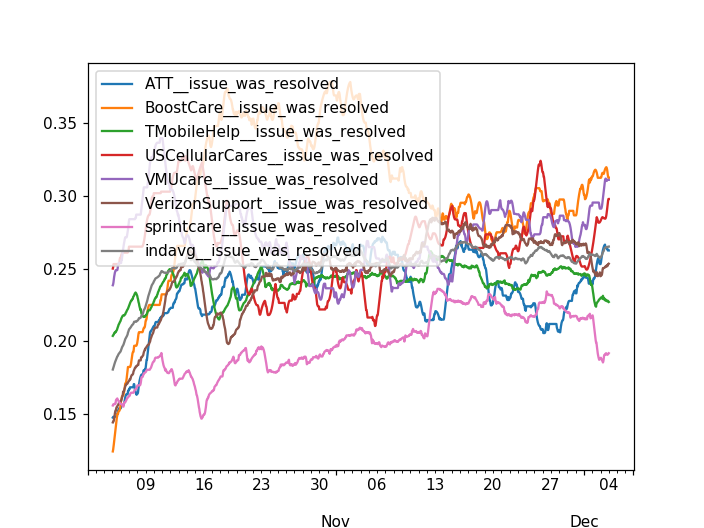

In [7]:
# combine and save as df

def prepend_compname(df, comp):
    cols = [c for c in df if c != "time"]
    cols_new = [comp + "__" + c for c in cols]
    return df.rename(columns = dict(zip(cols, cols_new)))

dfs_prepended = [prepend_compname(v, k) for k, v in comp2df_strd.items()]
timeserie_df = pd.concat(dfs_prepended,
                axis = "columns")

## industry average cols

# getting metrics
cols = list(timeserie_df)
sep = "__"
# unique metrics
mets = list(set([c[c.index(sep) + len(sep) : None] for c in cols]))

# adding indavg (industry average) cols
for met in mets:
    # avg met over companies
    metcols = [c for c in cols if met in c]
    metavgs = timeserie_df[metcols].values.mean(axis = 1)
    timeserie_df["indavg__" + met] = metavgs

# saving
timeserie_df.to_csv("data/timeseries.csv")
timeserie_df.plot(y = [c for c in timeserie_df 
                       if "issue_was_resolved" in c])